# Florescent-Florescent Diffeomorphic Demons Image Registration
This notebook is adapted from https://github.com/airlab-unibas/airlab/blob/master/examples/demons_registration_2d.py

- Fixed image: DK52
- Moving image: DK43

In [1]:
import airlab as al
import numpy as np
import torch

import utility as util

## Load images

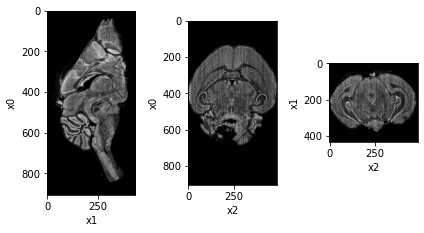

In [2]:
fixed_image = np.load('../data/ff/fixed_image.npy')
fixed_image = util.normalize_intensity(fixed_image)
util.imshow_midslice(fixed_image)

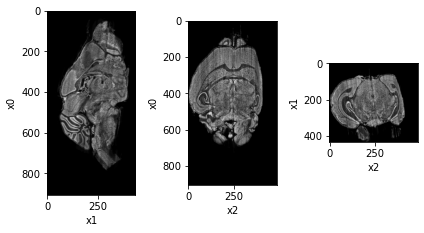

In [3]:
moving_image = np.load('../data/ff/moving_image_after_linear_reg.npy')
moving_image = util.normalize_intensity(moving_image)
util.imshow_midslice(moving_image)

## Prepare images for registration

In [4]:
dtype = torch.float32
device = torch.device('cpu')
scales = [1, 1, 1]

fixed_image = torch.tensor(fixed_image, dtype=dtype).to(device)
fixed_image = al.Image(fixed_image, fixed_image.shape, scales, [0, 0, 0])
moving_iamge = torch.tensor(moving_image, dtype=dtype).to(device)
moving_image = al.Image(moving_image, moving_image.shape, scales, [0, 0, 0])

## Prepare image pyramid

In [5]:
scales = [[4, 4, 4], [2, 2, 2]]

fixed_image_pyramid = al.create_image_pyramid(fixed_image, scales)
moving_image_pyramid = al.create_image_pyramid(moving_image, scales)
level_max = len(fixed_image_pyramid) - 1

## Run registration

In [6]:
lr = 1e-2
niter = [64, 8, 1]
sigma = [[2, 2, 2], [2, 2, 2], [2, 2, 2]]

In [7]:
import time

start = time.time()

for level, (mov_im, fix_im) in enumerate(zip(moving_image_pyramid, fixed_image_pyramid)):
    print('level', level)
    registration = al.DemonsRegistraion(verbose=True)

    transformation = al.transformation.pairwise.NonParametricTransformation(
        mov_im.size,
        diffeomorphic=True
    )
    if level > 0:
        constant_flow = al.transformation.utils.upsample_displacement(
            constant_flow,
            mov_im.size,
            interpolation="linear"
        )
        transformation.set_constant_flow(constant_flow)
    registration.set_transformation(transformation)

    image_loss = al.loss.pairwise.MSE(fix_im, mov_im)
    registration.set_image_loss([image_loss])

    regulariser = al.regulariser.demons.GaussianRegulariser(
        mov_im.spacing,
        sigma=sigma[level]
    )
    registration.set_regulariser([regulariser])

    optimizer = torch.optim.Adam(transformation.parameters())
    registration.set_optimizer(optimizer)
    registration.set_number_of_iterations(niter[level])

    registration.start()

    constant_flow = transformation.get_flow()

end = time.time()
print((end - start) / 60, 'min')

level 0
0 

/home/b2dong/registration-study/env/lib/python3.8/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


mse: 0.0045084482795363775 


/home/b2dong/registration-study/env/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


1 mse: 0.004425561598092275 
2 mse: 0.004351537737951681 
3 mse: 0.004293673305109685 
4 mse: 0.0042458459944219465 
5 mse: 0.004205273977258586 
6 mse: 0.004169994575643147 
7 mse: 0.004138744369754883 
8 mse: 0.004111888450742267 
9 mse: 0.004087545622777926 
10 mse: 0.004065311089144159 
11 mse: 0.004045147261609192 
12 mse: 0.004026226514202571 
13 mse: 0.004008150754343711 
14 mse: 0.003990747342852276 
15 mse: 0.0039744675387357676 
16 mse: 0.003958959986158278 
17 mse: 0.00394369840422587 
18 mse: 0.003928823738477194 
19 mse: 0.003914412994858007 
20 mse: 0.0039001661347775702 
21 mse: 0.0038859171986578155 
22 mse: 0.0038718294727632676 
23 mse: 0.003858380638682875 
24 mse: 0.003845427010983084 
25 mse: 0.003833029615045579 
26 mse: 0.0038212787372946394 
27 mse: 0.00381010685447091 
28 mse: 0.003799555199196172 
29 mse: 0.0037896038803108337 
30 mse: 0.0037800573570383766 
31 mse: 0.0037708228566374707 
32 mse: 0.0037617990416227657 
33 mse: 0.003753018689136336 
34 mse: 0.0

## Examine results

In [8]:
transformation

NonParametricTransformation()

In [9]:
displacement = transformation.get_displacement()
warped_image = al.transformation.utils.warp_image(moving_image, displacement)
np.save('../data/ff/moving_image_after_demons_reg.npy', warped_image.image[0,0].numpy())

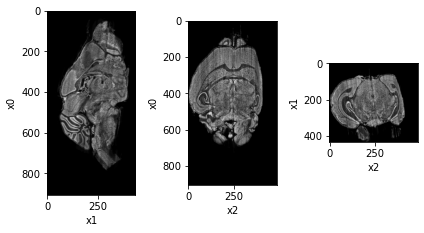

In [10]:
util.imshow_midslice(moving_image.image[0,0].numpy())

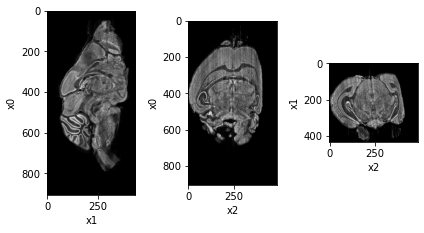

In [11]:
util.imshow_midslice(warped_image.image[0,0].numpy())

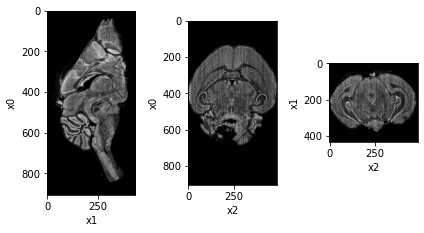

In [12]:
util.imshow_midslice(fixed_image.image[0,0].numpy())